In [1]:
import numpy as np
import tensorflow as tf
from pathlib import Path
import cv2

In [2]:
import shutil
import os
from pathlib import Path

# Set your paths - using absolute path
SOURCE_DATASET = Path(r"d:\Lohith\BTECH CODES\Machine_Learning\Project\Crop-Disease\plantvillage-dataset\plantvillage dataset\color")
DESTINATION_DATASET = Path(r"d:\Lohith\BTECH CODES\Machine_Learning\Project\Crop-Disease\filtered_data")

# List of folders we want to include
TARGET_CLASSES = [
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Pepper,_bell___healthy",
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Strawberry___healthy",
    "Strawberry___Leaf_scorch",
]

# Create destination if it doesn't exist
DESTINATION_DATASET.mkdir(exist_ok=True)

print("🚀 Starting dataset filtering...")

for class_name in TARGET_CLASSES:
    source_folder = SOURCE_DATASET / class_name
    dest_folder = DESTINATION_DATASET / class_name
    
    if source_folder.exists():
        if not dest_folder.exists():
            print(f"📁 Copying {class_name}...")
            shutil.copytree(source_folder, dest_folder)
        else:
            print(f"✅ {class_name} already exists in filtered set.")
    else:
        print(f"⚠️ Warning: Could not find {class_name} in source!")

print("\n✨ Filtering complete. Your 'filtered_data' folder is ready for training.")

🚀 Starting dataset filtering...
✅ Tomato___Early_blight already exists in filtered set.
✅ Tomato___Late_blight already exists in filtered set.
✅ Tomato___Tomato_Yellow_Leaf_Curl_Virus already exists in filtered set.
✅ Tomato___healthy already exists in filtered set.
✅ Potato___Early_blight already exists in filtered set.
✅ Potato___Late_blight already exists in filtered set.
✅ Potato___healthy already exists in filtered set.
✅ Corn_(maize)___Common_rust_ already exists in filtered set.
✅ Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot already exists in filtered set.
✅ Corn_(maize)___Northern_Leaf_Blight already exists in filtered set.
✅ Corn_(maize)___healthy already exists in filtered set.
✅ Pepper,_bell___Bacterial_spot already exists in filtered set.
✅ Pepper,_bell___healthy already exists in filtered set.
✅ Apple___Apple_scab already exists in filtered set.
✅ Apple___Black_rot already exists in filtered set.
✅ Apple___Cedar_apple_rust already exists in filtered set.
✅ Apple___he

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

# --- Configuration ---
BASE_DIR = Path.cwd()
DATASET_PATH = BASE_DIR / "filtered_data"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Image Data Augmentation (Crucial for multi-crop variety)
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,    # 20% of data for testing accuracy
    rotation_range=25,       # Randomly rotate photos
    zoom_range=0.2,          # Randomly zoom in
    horizontal_flip=True,    # Flip images horizontally
    fill_mode="nearest"
)

# 2. Load Training Data
train_data = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# 3. Load Validation Data
val_data = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# 4. Save the Label Map (The index to name dictionary)
NUM_CLASSES = train_data.num_classes
labels = train_data.class_indices
with open("new_label_map.txt", "w") as f:
    for name, index in labels.items():
        f.write(f"{index}:{name}\n")

print(f"✅ Setup complete! Found {NUM_CLASSES} classes across your selected crops.")

Found 18463 images belonging to 19 classes.
Found 4609 images belonging to 19 classes.
✅ Setup complete! Found 19 classes across your selected crops.


In [4]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Calculate weights to give "extra attention" to rare diseases
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [5]:
from tensorflow.keras import layers, models

# 1. Load the pre-trained MobileNetV2 (without the top classification layer)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False, 
    weights="imagenet"
)

# 2. Freeze the base model so we don't destroy pre-trained features
base_model.trainable = False 

# 3. Add your custom "Head" for the 13 classes
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Converts 2D features to a 1D vector
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),              # Prevents overfitting
    layers.Dense(NUM_CLASSES, activation='softmax') # The output for 13 classes
])

# 4. Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape          ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224         │ (None, 7, 7, 1280)    │   2,257,984 │
│ (Functional)                 │                       │             │
├──────────────────────────────┼───────────────────────┼─────────────┤
│ global_average_pooling2d     │ (None, 1280)          │           0 │
│ (GlobalAveragePooling2D)     │                       │             │
├──────────────────────────────┼───────────────────────┼─────────────┤
│ dense (Dense)                │ (None, 256)           │     327,936 │
├──────────────────────────────┼───────────────────────┼─────────────┤
│ dropout (Dropout)            │ (None, 256)           │           0 │
├──────────────────────────────┼───────────────────────┼─────────────┤
│ dense_1 (Dense)              │ (None, 19)            │       4,883 │
└──────────────────────────────┴───────────────────────┴─────────────┘

 Total params: 2,590,803 (9.88 MB)

 Trainable params: 332,819 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Define where to save the best model
MODEL_NAME = "crop_disease_master_model.keras"

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

# 5. Start the Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,             # Start with 15; EarlyStopping will handle the rest
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/15
577/577 ━━━━━━━━━━━━━━━━━━━━ 456s 785ms/step - accuracy: 0.7742 - loss: 0.8048 - val_accuracy: 0.9178 - val_loss: 0.2576 - learning_rate: 3.0000e-04
Epoch 2/15
577/577 ━━━━━━━━━━━━━━━━━━━━ 251s 434ms/step - accuracy: 0.9062 - loss: 0.3123 - val_accuracy: 0.9462 - val_loss: 0.1725 - learning_rate: 3.0000e-04
Epoch 3/15
577/577 ━━━━━━━━━━━━━━━━━━━━ 257s 445ms/step - accuracy: 0.9283 - loss: 0.2325 - val_accuracy: 0.9536 - val_loss: 0.1452 - learning_rate: 3.0000e-04
Epoch 4/15
577/577 ━━━━━━━━━━━━━━━━━━━━ 279s 483ms/step - accuracy: 0.9404 - loss: 0.1908 - val_accuracy: 0.9475 - val_loss: 0.1531 - learning_rate: 3.0000e-04
Epoch 5/15
577/577 ━━━━━━━━━━━━━━━━━━━━ 265s 460ms/step - accuracy: 0.9440 - loss: 0.1673 - val_accuracy: 0.9479 - val_loss: 0.1481 - learning_rate: 3.0000e-04
Epoch 6/15
577/577 ━━━━━━━━━━━━━━━━━━━━ 256s 444ms/step - accuracy: 0.9547 - loss: 0.1401 - val_accuracy: 0.9640 - val_loss: 0.1007 - learning_rate: 1.5000e-04
Epoch 7/15
577/577 ━━━━━━━━━━━━━━━━━━━━ 

In [7]:
# Load the best version that was saved during training
model = tf.keras.models.load_model(MODEL_NAME)

# Check the final accuracy scores
val_acc = history.history['val_accuracy'][-1]
print(f"✅ Training Complete! Validation Accuracy: {val_acc*100:.2f}%")

✅ Training Complete! Validation Accuracy: 97.20%


Generating predictions for 13 classes...
145/145 ━━━━━━━━━━━━━━━━━━━━ 48s 332ms/step


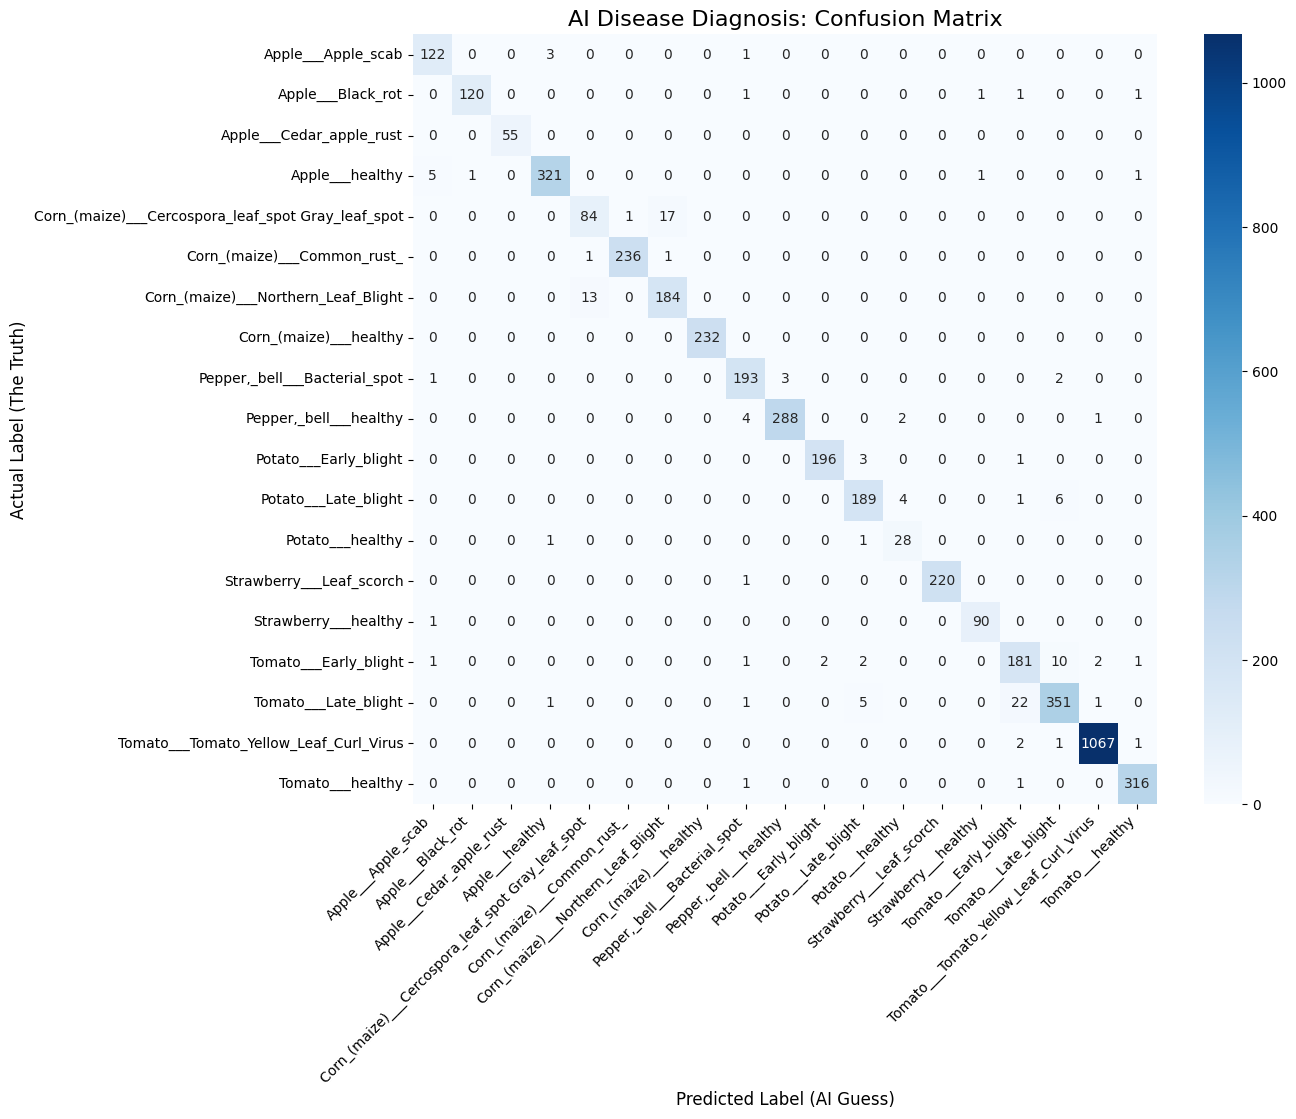


--- Detailed Classification Report ---

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.97      0.95       126
                                 Apple___Black_rot       0.99      0.97      0.98       124
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        55
                                   Apple___healthy       0.98      0.98      0.98       329
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.82      0.84       102
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       238
               Corn_(maize)___Northern_Leaf_Blight       0.91      0.93      0.92       197
                            Corn_(maize)___healthy       1.00      1.00      1.00       232
                     Pepper,_bell___Bacterial_spot       0.95      0.97      0.96       199
                            Pepper,_be

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get the 'True' labels from the validation generator
# We set shuffle=False earlier so the order matches the predictions
y_true = val_data.classes 

# 2. Get the AI's 'Predicted' labels
print("Generating predictions for 13 classes...")
predictions = model.predict(val_data)
y_pred = np.argmax(predictions, axis=1)

# 3. Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Get the class names from the label map for the axis labels
class_names = list(val_data.class_indices.keys())

# 5. Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

plt.title('AI Disease Diagnosis: Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label (The Truth)', fontsize=12)
plt.xlabel('Predicted Label (AI Guess)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# 6. Print the text report (Precision, Recall, F1-Score)
print("\n--- Detailed Classification Report ---\n")
print(classification_report(y_true, y_pred, target_names=class_names))